In [11]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import os, shutil, random
import pylangacq
import random
import nltk
import glob, re
from nltk.tokenize import sent_tokenize
import librosa
import warnings
import networkx as nx
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
base_dir = "Pitt"
for group in ["Control", "Dementia"]:
    cookie_dir = os.path.join(base_dir, group, "cookie")
    cha_files = [f for f in os.listdir(cookie_dir) if f.endswith(".cha")]
    random.shuffle(cha_files)
    split = int(0.8 * len(cha_files))
    train, test = cha_files[:split], cha_files[split:]
    
    for subset, filelist in zip(["train", "test"], [train, test]):
        dest_dir = os.path.join(base_dir, group, f"cookie_{subset}")
        os.makedirs(dest_dir, exist_ok=True)
        for f in filelist:
            shutil.copy(os.path.join(cookie_dir, f),
                        os.path.join(dest_dir, f))


In [3]:
def transcript_from_utterance(u, participant_code="PAR"):
    # Prefer original tier text if available; else join token words
    if getattr(u, "tiers", None) and participant_code in u.tiers and isinstance(u.tiers[participant_code], str):
        return u.tiers[participant_code]
    if getattr(u, "tokens", None):
        try:
            return " ".join(t.word for t in u.tokens if getattr(t, "word", None))
        except Exception:
            pass
    return ""

def _collect_utts(reader, codes=("PAR","PAT","CHI")):
    # Try multiple participant codes; return first non-empty list
    for code in codes:
        utts = reader.utterances(participants=code)
        if len(utts) > 0:
            return utts, code
    return [], None

def process_chat_folder(folder_path, label, participant_priorities=("PAR","PAT","CHI")):
    rows = []
    cha_files = sorted(glob.glob(f"{folder_path}/*.cha"))  # deterministic
    for cha_file in cha_files:
        try:
            reader = pylangacq.read_chat(cha_file)
            utts, used_code = _collect_utts(reader, participant_priorities)

            # Gather lines from the chosen participant
            lines = [transcript_from_utterance(u, used_code or "PAR") for u in utts]
            text = " ".join(lines).lower().strip()

            # Skip if empty (no participant speech)
            if not text:
                continue

            # --- Build the two versions ---
            # text_full: keep fillers, drop bracketed CHAT annotations like [//], [* xxx], etc.
            text_full = re.sub(r'\[[^\]]*\]', ' ', text)       # remove [...] blocks
            text_full = re.sub(r'\(\(.*?\)\)', ' ', text_full)  # remove ((...)) if present
            text_full = re.sub(r'\b(xxx|yyy|www)\b', ' ', text_full)
            text_full = re.sub(r'\s+', ' ', text_full).strip()

            # text_clean: remove common fillers from text_full
            fillers = r'\b(um+|uh+|erm+|hmm+|ah+|eh+|mm+|uh-huh+|um-hum+)\b'
            text_clean = re.sub(fillers, ' ', text_full)
            text_clean = re.sub(r'\s+', ' ', text_clean).strip()

            rows.append({
                "filename": os.path.basename(cha_file),
                "text_full": text_full,
                "text_clean": text_clean,
                "label": label
            })
        except Exception as e:
            print(f"Error in {cha_file}: {e}")

    return pd.DataFrame(rows)

# Paths (case-sensitive)
train_control   = "Pitt/Control/cookie_train"
test_control    = "Pitt/Control/cookie_test"
train_dementia  = "Pitt/Dementia/cookie_train"
test_dementia   = "Pitt/Dementia/cookie_test"

train_df = pd.concat([
    process_chat_folder(train_control, "control"),
    process_chat_folder(train_dementia, "dementia")
], ignore_index=True)

test_df = pd.concat([
    process_chat_folder(test_control, "control"),
    process_chat_folder(test_dementia, "dementia")
], ignore_index=True)

train_df.to_csv("cleaned_train_dual.csv", index=False)
test_df.to_csv("cleaned_test_dual.csv", index=False)

print(f"Done! Saved {len(train_df)} training and {len(test_df)} testing samples.")
print("Columns: filename | text_full | text_clean | label")


Done! Saved 441 training and 111 testing samples.
Columns: filename | text_full | text_clean | label


In [4]:
# Load your cleaned datasets
train_df = pd.read_csv("cleaned_train_dual.csv")
test_df = pd.read_csv("cleaned_test_dual.csv")

# Count samples per class
print("TRAINING SET:")
print(train_df["label"].value_counts(), "\n")

print("TEST SET:")
print(test_df["label"].value_counts(), "\n")


TRAINING SET:
label
dementia    247
control     194
Name: count, dtype: int64 

TEST SET:
label
dementia    62
control     49
Name: count, dtype: int64 



In [5]:
from sentence_transformers import models, SentenceTransformer

# Load the transformer weights & tokenizer
we = models.Transformer('models/all-mpnet-base-v2/0_Transformer')  # mpnet-base model

# Load the pooling module from its config (exact settings)
pool = models.Pooling.load('models/all-mpnet-base-v2/1_Pooling')

# Build the SentenceTransformer stack
model = SentenceTransformer(modules=[we, pool])

# (optional) set max sequence length like the original
model.max_seq_length = 512

print(model)
# quick test
print(model.encode(["Alzheimer's affects memory and speech."]).shape)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False, 'architecture': 'MPNetModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
(1, 768)


In [6]:

# Reproducibility
random.seed(42); np.random.seed(42)

# Use existing model if present; otherwise build via force-load
try:
    _ = model.get_sentence_embedding_dimension()
    print("Using existing model in memory.")
except NameError:
    from sentence_transformers import models, SentenceTransformer
    we = models.Transformer('models/all-mpnet-base-v2/0_Transformer')
    pool = models.Pooling.load('models/all-mpnet-base-v2/1_Pooling')
    model = SentenceTransformer(modules=[we, pool])
    model.max_seq_length = 512
    print("Rebuilt model from local folders.")


Using existing model in memory.


In [7]:
def embed_doc(text, batch_size=16):
    sents = [s.strip() for s in sent_tokenize(str(text)) if s.strip()]
    if not sents:
        return np.zeros(model.get_sentence_embedding_dimension(), dtype=np.float32)
    embs = model.encode(
        sents, batch_size=batch_size,
        show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True
    )
    return embs.mean(axis=0)

def embed_frame(csv_path, text_col="text_full", out_npy="semantic.npy"):
    df = pd.read_csv(csv_path)
    mat = np.vstack([embed_doc(t) for t in df[text_col].tolist()])
    np.save(out_npy, mat)
    print(f"{csv_path} → {out_npy} {mat.shape}")
    return mat

sem_train = embed_frame("cleaned_train_dual.csv", out_npy="semantic_train.npy")
sem_test  = embed_frame("cleaned_test_dual.csv",  out_npy="semantic_test.npy")

cleaned_train_dual.csv → semantic_train.npy (441, 768)
cleaned_test_dual.csv → semantic_test.npy (111, 768)


In [8]:
def _sent_lengths(txt):
    sents = sent_tokenize(str(txt))
    lens = [len(re.findall(r"\w+", s)) for s in sents]
    return [L for L in lens if L > 0]

def hvg_stats(lens):
    n = len(lens)
    if n < 3:
        return dict(hvg_avg_deg=0., hvg_clust=0., hvg_density=0.)
    G = nx.Graph(); G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if all(lens[k] < min(lens[i], lens[j]) for k in range(i+1, j)):
                G.add_edge(i, j)
    degs = [d for _, d in G.degree()]
    return dict(
        hvg_avg_deg=float(np.mean(degs)),
        hvg_clust=float(nx.average_clustering(G)) if G.number_of_edges() else 0.,
        hvg_density=float(nx.density(G))
    )

def nvg_light_stats(lens):
    # NVG-light: connect i<j if line of sight not blocked (strict)
    n = len(lens)
    if n < 3:
        return dict(nvg_avg_deg=0., nvg_density=0.)
    G = nx.Graph(); G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            ok = True
            for k in range(i+1, j):
                # strict “above the line” condition
                yij = lens[i] + (lens[j] - lens[i]) * (k - i) / (j - i)
                if lens[k] >= yij:
                    ok = False; break
            if ok: G.add_edge(i, j)
    degs = [d for _, d in G.degree()]
    return dict(
        nvg_avg_deg=float(np.mean(degs)),
        nvg_density=float(nx.density(G))
    )

def graph_row(text):
    lens = _sent_lengths(text)
    d = {}
    d.update(hvg_stats(lens))
    d.update(nvg_light_stats(lens))
    d.update(
        n_sent=len(lens),
        len_mean=float(np.mean(lens) if lens else 0.),
        len_std=float(np.std(lens) if lens else 0.)
    )
    return d

def graph_from_csv(in_csv, out_csv, text_col="text_full"):
    df = pd.read_csv(in_csv)
    feats = [graph_row(t) for t in df[text_col]]
    gdf = pd.DataFrame(feats)
    gdf.insert(0, "filename", df["filename"])
    gdf.to_csv(out_csv, index=False)
    print(f"saved {out_csv} {gdf.shape}")

graph_from_csv("cleaned_train_dual.csv", "graph_train.csv")
graph_from_csv("cleaned_test_dual.csv",  "graph_test.csv")

saved graph_train.csv (441, 9)
saved graph_test.csv (111, 9)


In [9]:
# ---- Data alignment (assumes these files already exist) ----
train_df = pd.read_csv("cleaned_train_dual.csv")
test_df  = pd.read_csv("cleaned_test_dual.csv")
y_train = (train_df["label"]=="dementia").astype(int).to_numpy()
y_test  = (test_df["label"]=="dementia").astype(int).to_numpy()

# Semantic embeddings (MPNet)
sem_train = np.load("semantic_train.npy")     # (N_train, 768)
sem_test  = np.load("semantic_test.npy")      # (N_test, 768)

# Graph features with HVG/NVG prefixes
gtr = pd.read_csv("graph_train.csv").set_index("filename").loc[train_df["filename"]].reset_index(drop=True)
gte = pd.read_csv("graph_test.csv").set_index("filename").loc[test_df["filename"]].reset_index(drop=True)

graph_cols  = [c for c in gtr.columns if c != "filename"]
shared_cols = [c for c in ["n_sent","len_mean","len_std"] if c in graph_cols]
hvg_cols    = [c for c in graph_cols if c.startswith("hvg_")]
nvg_cols    = [c for c in graph_cols if c.startswith("nvg_")]

def build_graph_slice(train_df, test_df, main_cols, shared_cols):
    cols = [c for c in (main_cols + shared_cols) if c in train_df.columns]
    Xtr = train_df[cols].to_numpy()
    Xte = test_df[cols].to_numpy()
    sc  = StandardScaler()
    return sc.fit_transform(Xtr), sc.transform(Xte)

# Graph-only slices (scaled)
Xg_hvg_tr,  Xg_hvg_te  = build_graph_slice(gtr, gte, hvg_cols, shared_cols)
Xg_nvg_tr,  Xg_nvg_te  = build_graph_slice(gtr, gte, nvg_cols, shared_cols)

# Graph both = all graph columns (already includes hvg_, nvg_, shared)
sc_all = StandardScaler()
Xg_both_tr = sc_all.fit_transform(gtr[graph_cols].to_numpy())
Xg_both_te = sc_all.transform(gte[graph_cols].to_numpy())

# Semantic-only
X_sem_tr, X_sem_te = sem_train, sem_test

# Fusions
Xs_hvg_tr,  Xs_hvg_te  = np.hstack([sem_train, Xg_hvg_tr]),  np.hstack([sem_test, Xg_hvg_te])
Xs_nvg_tr,  Xs_nvg_te  = np.hstack([sem_train, Xg_nvg_tr]),  np.hstack([sem_test, Xg_nvg_te])
Xs_both_tr, Xs_both_te = np.hstack([sem_train, Xg_both_tr]), np.hstack([sem_test, Xg_both_te])

# ---- Tuner + evaluator ----
def tune_rf(X, y, n_iter=30):
    rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
    param_dist = {
        "n_estimators": randint(250, 650),
        "max_depth": randint(8, 40),
        "min_samples_split": randint(2, 12),
        "min_samples_leaf": randint(1, 8),
        "max_features": uniform(0.2, 0.7),
        "bootstrap": [True, False],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = RandomizedSearchCV(
        rf, param_dist, n_iter=n_iter, scoring="roc_auc",
        n_jobs=-1, cv=cv, verbose=0, random_state=42
    )
    search.fit(X, y)
    return search.best_estimator_, search.best_score_, search.best_params_

def eval_rf(Xtr, ytr, Xte, yte, n_iter=30):
    best, cv_auc, best_params = tune_rf(Xtr, ytr, n_iter=n_iter)
    best.fit(Xtr, ytr)
    p = best.predict(Xte)
    s = best.predict_proba(Xte)[:,1]
    return dict(
        CV_AUC=round(cv_auc,3),
        Test_AUC=round(roc_auc_score(yte, s),3),
        Acc=round(accuracy_score(yte, p),3),
        F1=round(f1_score(yte, p),3),
        Best_Params=best_params
    )

# ---- Run all 7 combinations (no acoustic) ----
ablations = {
    "Semantic only":           eval_rf(X_sem_tr,   y_train, X_sem_te,   y_test, n_iter=30),
    "Graph(HVG) only":         eval_rf(Xg_hvg_tr,  y_train, Xg_hvg_te,  y_test, n_iter=30),
    "Graph(NVG) only":         eval_rf(Xg_nvg_tr,  y_train, Xg_nvg_te,  y_test, n_iter=30),
    "Graph(Both) only":        eval_rf(Xg_both_tr, y_train, Xg_both_te, y_test, n_iter=30),
    "Semantic + HVG":          eval_rf(Xs_hvg_tr,  y_train, Xs_hvg_te,  y_test, n_iter=30),
    "Semantic + NVG":          eval_rf(Xs_nvg_tr,  y_train, Xs_nvg_te,  y_test, n_iter=30),
    "Semantic + Both (S+G)":   eval_rf(Xs_both_tr, y_train, Xs_both_te, y_test, n_iter=30),
}

abl_table = pd.DataFrame(ablations).T[["CV_AUC","Test_AUC","Acc","F1","Best_Params"]]
abl_table = abl_table.sort_values("Test_AUC", ascending=False)
print(abl_table)
abl_table.to_csv("results_rf_sem_vs_graph_ablations.csv")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

                      CV_AUC Test_AUC    Acc     F1  \
Semantic + HVG         0.857    0.788  0.703  0.744   
Semantic + NVG         0.861    0.778  0.712  0.754   
Semantic + Both (S+G)  0.858    0.775  0.703  0.744   
Semantic only          0.858    0.772  0.703  0.748   
Graph(NVG) only        0.556    0.589  0.577  0.605   
Graph(Both) only       0.589    0.582  0.541  0.611   
Graph(HVG) only        0.606    0.551  0.514  0.578   

                                                             Best_Params  
Semantic + HVG         {'bootstrap': True, 'max_depth': 34, 'max_feat...  
Semantic + NVG         {'bootstrap': True, 'max_depth': 31, 'max_feat...  
Semantic + Both (S+G)  {'bootstrap': True, 'max_depth': 34, 'max_feat...  
Semantic only          {'bootstrap': True, 'max_depth': 19, 'max_feat...  
Graph(NVG) only        {'bootstrap': False, 'max_depth': 16, 'max_fea...  
Graph(Both) only       {'bootstrap': True, 'max_depth': 20, 'max_feat...  
Graph(HVG) only        {'bootstrap

In [10]:
# ---------------------------
# 1) Data and graph slices
# ---------------------------
train_df = pd.read_csv("cleaned_train_dual.csv")
test_df  = pd.read_csv("cleaned_test_dual.csv")

# (already computed)
sem_train = np.load("semantic_train.npy").astype(np.float32)
sem_test  = np.load("semantic_test.npy").astype(np.float32)

# align graph features
gtr_raw = pd.read_csv("graph_train.csv").set_index("filename").loc[train_df["filename"]].reset_index(drop=True)
gte_raw = pd.read_csv("graph_test.csv").set_index("filename").loc[test_df["filename"]].reset_index(drop=True)

graph_cols  = [c for c in gtr_raw.columns if c != "filename"]
shared_cols = [c for c in ["n_sent","len_mean","len_std"] if c in graph_cols]
hvg_cols    = [c for c in graph_cols if c.startswith("hvg_")]
nvg_cols    = [c for c in graph_cols if c.startswith("nvg_")]

def build_graph_slice(gtr, gte, main_cols, shared_cols):
    cols = [c for c in (main_cols + shared_cols) if c in gtr.columns]
    sc = StandardScaler().fit(gtr[cols].to_numpy())
    Xtr = sc.transform(gtr[cols].to_numpy()).astype(np.float32)
    Xte = sc.transform(gte[cols].to_numpy()).astype(np.float32)
    return Xtr, Xte

G_HVG_tr, G_HVG_te = build_graph_slice(gtr_raw, gte_raw, hvg_cols, shared_cols)
G_NVg_tr, G_NVg_te = build_graph_slice(gtr_raw, gte_raw, nvg_cols, shared_cols)

# Both = all graph columns (already includes hvg_, nvg_, shared)
sc_all = StandardScaler().fit(gtr_raw[graph_cols].to_numpy())
G_BOTH_tr = sc_all.transform(gtr_raw[graph_cols].to_numpy()).astype(np.float32)
G_BOTH_te = sc_all.transform(gte_raw[graph_cols].to_numpy()).astype(np.float32)

# labels
y_train = (train_df["label"]=="dementia").astype(np.float32).to_numpy()
y_test  = (test_df["label"]=="dementia").astype(np.float32).to_numpy()

# ---------------------------
# 2) Sentence-embed sequence maker (uses your already-built ST `model`)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def sent_embed_list(text):
    sents = [s.strip() for s in sent_tokenize(str(text)) if s.strip()]
    if not sents:
        return np.zeros((1, model.get_sentence_embedding_dimension()), dtype=np.float32)
    embs = model.encode(
        sents, batch_size=16, show_progress_bar=False,
        convert_to_numpy=True, normalize_embeddings=True
    )
    return embs.astype(np.float32)  # [T, 768]

class SeqDataset(Dataset):
    def __init__(self, csv_path, side_vec=None, text_col="text_full"):
        self.df = pd.read_csv(csv_path)
        self.texts = self.df[text_col].tolist()
        self.labels = (self.df["label"]=="dementia").astype(np.float32).to_numpy()
        self.side = side_vec  # (N, d) or None
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        X = sent_embed_list(self.texts[idx])  # [T,768]
        y = self.labels[idx]
        side = None if self.side is None else self.side[idx].astype(np.float32)
        return X, y, side

def collate_pad(batch):
    seqs, ys, sides = zip(*batch)
    lengths = torch.tensor([s.shape[0] for s in seqs], dtype=torch.long)
    T = int(lengths.max().item()); D = seqs[0].shape[1]
    X = torch.zeros(len(seqs), T, D, dtype=torch.float32)
    for i, s in enumerate(seqs):
        X[i, :s.shape[0], :] = torch.from_numpy(s)
    y = torch.tensor(ys, dtype=torch.float32)
    side = None if sides[0] is None else torch.from_numpy(np.vstack(sides)).float()
    return X, lengths, y, side

# ---------------------------
# 3) BiLSTM + Attention
# ---------------------------
class AttentionPool(nn.Module):
    def __init__(self, d_model, attn_dim=128):
        super().__init__()
        self.w = nn.Linear(d_model, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
    def forward(self, H, mask):
        scores = self.v(torch.tanh(self.w(H))).squeeze(-1)  # [B,T]
        scores = scores.masked_fill(~mask, float("-inf"))
        alpha = torch.softmax(scores, dim=-1)
        ctx = torch.sum(H * alpha.unsqueeze(-1), dim=1)     # [B,D]
        return ctx

class BiLSTMAttnClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden=128, num_layers=1, dropout=0.2, side_dim=0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=num_layers,
                            batch_first=True, bidirectional=True,
                            dropout=0.0 if num_layers==1 else dropout)
        self.attn = AttentionPool(2*hidden, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden + side_dim, 128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
    def forward(self, x, lengths, side=None):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        H_packed, _ = self.lstm(packed)
        H, _ = nn.utils.rnn.pad_packed_sequence(H_packed, batch_first=True)  # [B,T,2H]
        B,T,D = H.shape
        idx = torch.arange(T, device=H.device)[None,:].expand(B,T)
        mask = idx < lengths.unsqueeze(1)
        ctx = self.attn(H, mask)                               # [B, 2H]
        if side is not None: ctx = torch.cat([ctx, side], 1)   # concat side vector AFTER attention
        return self.fc(self.dropout(ctx)).squeeze(1)           # logits

# ---------------------------
# 4) Runner (semantic-primary; optional graph side)
# ---------------------------
def run_bilstm_semantic(train_csv, test_csv, side_train=None, side_test=None, epochs=16, lr=1e-3):
    # standardize side vectors if provided
    scaler = None
    if side_train is not None:
        scaler = StandardScaler().fit(side_train)
        side_train = scaler.transform(side_train).astype(np.float32)
        side_test  = scaler.transform(side_test ).astype(np.float32)

    tr = SeqDataset(train_csv, side_vec=side_train)
    te = SeqDataset(test_csv,  side_vec=side_test)
    tr_loader = DataLoader(tr, batch_size=8, shuffle=True,  collate_fn=collate_pad)
    te_loader = DataLoader(te, batch_size=8, shuffle=False, collate_fn=collate_pad)

    model_bi = BiLSTMAttnClassifier(
        input_dim=768, hidden=128, num_layers=1, dropout=0.2,
        side_dim=(0 if side_train is None else side_train.shape[1])
    ).to(device)

    # imbalance handling
    pos = tr.labels.sum(); neg = len(tr)-pos
    pos_w = (neg / (pos + 1e-6))
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_w], device=device))
    opt = Adam(model_bi.parameters(), lr=lr, weight_decay=1e-5)

    best_auc, patience, wait = -1, 5, 0
    last_probs, last_true = None, None

    for ep in range(epochs):
        model_bi.train()
        for X,L,y,side in tr_loader:
            X,L,y = X.to(device), L.to(device), y.to(device)
            side = side.to(device) if side is not None else None
            logits = model_bi(X,L,side)
            loss = loss_fn(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()

        # eval
        model_bi.eval(); ys=[]; ps=[]
        with torch.no_grad():
            for X,L,y,side in te_loader:
                X,L = X.to(device), L.to(device)
                side = side.to(device) if side is not None else None
                prob = torch.sigmoid(model_bi(X,L,side)).cpu().numpy()
                ys.append(y.numpy()); ps.append(prob)
        ys = np.concatenate(ys); ps = np.concatenate(ps)
        auc = roc_auc_score(ys, ps)
        print(f"Epoch {ep+1:02d} | AUC {auc:.3f}")

        if auc > best_auc + 1e-4:
            best_auc, wait = auc, 0
            last_probs, last_true = ps.copy(), ys.copy()
        else:
            wait += 1
            if wait >= patience: break

    yhat = (last_probs >= 0.5).astype(int)
    print("\nBiLSTM (Semantic{}):".format("" if side_train is None else " + side"))
    print(classification_report(last_true, yhat, target_names=["Control","Dementia"]))
    print("Confusion matrix:\n", confusion_matrix(last_true, yhat))
    print("ROC-AUC:", round(roc_auc_score(last_true, last_probs), 3))
    return {"Test AUC": round(roc_auc_score(last_true, last_probs), 3),
            "Acc": round(accuracy_score(last_true, yhat), 3),
            "F1": round(f1_score(last_true, yhat), 3)}

# ---------------------------
# 5) Run semantic-primary + graph ablations
# ---------------------------
bilstm_results = {}
bilstm_results["Semantic only"]          = run_bilstm_semantic("cleaned_train_dual.csv","cleaned_test_dual.csv", epochs=16)
bilstm_results["Semantic + HVG"]         = run_bilstm_semantic("cleaned_train_dual.csv","cleaned_test_dual.csv",
                                                               side_train=G_HVG_tr, side_test=G_HVG_te, epochs=16)
bilstm_results["Semantic + NVG"]         = run_bilstm_semantic("cleaned_train_dual.csv","cleaned_test_dual.csv",
                                                               side_train=G_NVg_tr, side_test=G_NVg_te, epochs=16)
bilstm_results["Semantic + Both (S+G)"]  = run_bilstm_semantic("cleaned_train_dual.csv","cleaned_test_dual.csv",
                                                               side_train=G_BOTH_tr, side_test=G_BOTH_te, epochs=16)

bilstm_summary = pd.DataFrame({
    k: {"Test AUC": v["Test AUC"], "Acc": v["Acc"], "F1": v["F1"]}
    for k, v in bilstm_results.items()
}).T.sort_values("Test AUC", ascending=False)

print("\n=== BiLSTM (semantic-primary; graph ablations) ===\n", bilstm_summary)
bilstm_summary.to_csv("bilstm_semantic_graph_ablations.csv")


Device: cpu
Epoch 01 | AUC 0.767
Epoch 02 | AUC 0.763
Epoch 03 | AUC 0.790
Epoch 04 | AUC 0.794
Epoch 05 | AUC 0.785
Epoch 06 | AUC 0.794
Epoch 07 | AUC 0.807
Epoch 08 | AUC 0.817
Epoch 09 | AUC 0.827
Epoch 10 | AUC 0.838
Epoch 11 | AUC 0.824
Epoch 12 | AUC 0.837
Epoch 13 | AUC 0.832
Epoch 14 | AUC 0.829
Epoch 15 | AUC 0.836

BiLSTM (Semantic):
              precision    recall  f1-score   support

     Control       0.76      0.65      0.70        49
    Dementia       0.75      0.84      0.79        62

    accuracy                           0.76       111
   macro avg       0.76      0.75      0.75       111
weighted avg       0.76      0.76      0.75       111

Confusion matrix:
 [[32 17]
 [10 52]]
ROC-AUC: 0.838
Epoch 01 | AUC 0.782
Epoch 02 | AUC 0.773
Epoch 03 | AUC 0.821
Epoch 04 | AUC 0.822
Epoch 05 | AUC 0.813
Epoch 06 | AUC 0.827
Epoch 07 | AUC 0.817
Epoch 08 | AUC 0.835
Epoch 09 | AUC 0.831
Epoch 10 | AUC 0.837
Epoch 11 | AUC 0.824
Epoch 12 | AUC 0.847
Epoch 13 | AUC 0.844


In [13]:


# --- Setup ---
os.makedirs("figs", exist_ok=True)

# Load results
bilstm = pd.read_csv("bilstm_semantic_graph_ablations.csv", index_col=0)
rf     = pd.read_csv("results_rf_sem_vs_graph_ablations.csv", index_col=0)

# Normalize RF column names to match for plotting
rf = rf.rename(columns={"Test_AUC": "Test AUC", "CV_AUC": "CV AUC"})

# ---- 1) BiLSTM: Test AUC bar chart ----
plt.figure(figsize=(8,5))
order = bilstm.sort_values("Test AUC", ascending=False).index.tolist()
vals  = bilstm.loc[order, "Test AUC"].values
plt.bar(range(len(order)), vals)
plt.xticks(range(len(order)), order, rotation=20, ha="right")
plt.ylabel("Test AUC")
plt.title("BiLSTM + Attention (Semantic-primary) — Test AUC")
plt.tight_layout()
plt.savefig("figs/bilstm_test_auc.png", dpi=300)
plt.close()

# ---- 2) Random Forest: Test AUC bar chart ----
plt.figure(figsize=(8,5))
order_rf = rf.sort_values("Test AUC", ascending=False).index.tolist()
vals_rf  = rf.loc[order_rf, "Test AUC"].values
plt.bar(range(len(order_rf)), vals_rf)
plt.xticks(range(len(order_rf)), order_rf, rotation=20, ha="right")
plt.ylabel("Test AUC")
plt.title("Random Forest — Test AUC (Ablations)")
plt.tight_layout()
plt.savefig("figs/rf_test_auc.png", dpi=300)
plt.close()

# ---- 3) Side-by-side comparison (BiLSTM vs RF) for overlapping variants ----
# Pick common rows (rename so labels match nicely)
# We’ll compare: 'Semantic only', 'Semantic + HVG', 'Semantic + NVG', 'Semantic + Both (S+G)'
# Your RF labels might be:
#   'Semantic only', 'Semantic + HVG', 'Semantic + NVG', 'Semantic + Both (S+G)'
common_labels = [
    "Semantic only",
    "Semantic + HVG",
    "Semantic + NVG",
    "Semantic + Both (S+G)"
]

# Filter to those that actually exist
common_bi = [lab for lab in common_labels if lab in bilstm.index]
common_rf = [lab for lab in common_labels if lab in rf.index]
common = [lab for lab in common_bi if lab in common_rf]

# Build grouped bars
x = np.arange(len(common))
w = 0.38

plt.figure(figsize=(9,5))
plt.bar(x - w/2, bilstm.loc[common, "Test AUC"].values, width=w, label="BiLSTM")
plt.bar(x + w/2, rf.loc[common,     "Test AUC"].values, width=w, label="Random Forest")
plt.xticks(x, common, rotation=15, ha="right")
plt.ylabel("Test AUC")
plt.title("Semantic-Primary Feature Sets: BiLSTM vs Random Forest (Test AUC)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/compare_bilstm_vs_rf.png", dpi=300)
plt.close()

# ---- 4) (Optional) Accuracy/F1 bar charts for BiLSTM ----
plt.figure(figsize=(8,5))
idx = bilstm.index.tolist()
acc_vals = bilstm["Acc"].values
plt.bar(range(len(idx)), acc_vals)
plt.xticks(range(len(idx)), idx, rotation=20, ha="right")
plt.ylabel("Accuracy")
plt.title("BiLSTM + Attention — Accuracy")
plt.tight_layout()
plt.savefig("figs/bilstm_acc.png", dpi=300)
plt.close()

plt.figure(figsize=(8,5))
f1_vals = bilstm["F1"].values
plt.bar(range(len(idx)), f1_vals)
plt.xticks(range(len(idx)), idx, rotation=20, ha="right")
plt.ylabel("F1-score")
plt.title("BiLSTM + Attention — F1-score")
plt.tight_layout()
plt.savefig("figs/bilstm_f1.png", dpi=300)
plt.close()

print("Saved figures in ./figs:")
for f in sorted(os.listdir("figs")):
    print(" - figs/" + f)


Saved figures in ./figs:
 - figs/bilstm_acc.png
 - figs/bilstm_f1.png
 - figs/bilstm_test_auc.png
 - figs/compare_bilstm_vs_rf.png
 - figs/rf_test_auc.png


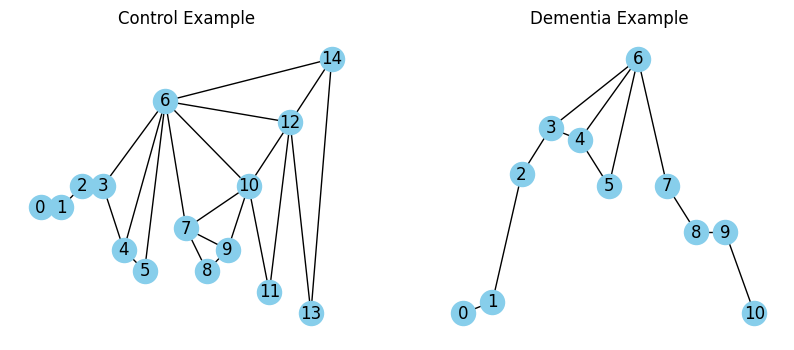

In [14]:
import re, networkx as nx, matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import pandas as pd, numpy as np

# Example: take one control and one dementia transcript
df = pd.read_csv("cleaned_train_dual.csv")
ex_control = df[df["label"]=="control"]["text_full"].iloc[0]
ex_dementia = df[df["label"]=="dementia"]["text_full"].iloc[0]

def sent_lens(text):
    sents = sent_tokenize(str(text))
    return [len(re.findall(r"\w+", s)) for s in sents if s.strip()]

def hvg_graph(lens):
    G = nx.Graph(); n = len(lens); G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if all(lens[k] < min(lens[i], lens[j]) for k in range(i+1, j)):
                G.add_edge(i, j)
    return G

# Pick a short portion for visualization (first 15 sentences)
lens_c = sent_lens(ex_control)[:15]
lens_d = sent_lens(ex_dementia)[:15]
G_c, G_d = hvg_graph(lens_c), hvg_graph(lens_d)

# Plot both
fig, axes = plt.subplots(1,2, figsize=(10,4))
for ax, G, title in zip(axes, [G_c, G_d], ["Control Example", "Dementia Example"]):
    pos = {i:(i, lens_c[i] if "Control" in title else lens_d[i]) for i in G.nodes()}
    nx.draw(G, pos, node_color="skyblue", node_size=300, with_labels=True, ax=ax)
    ax.set_title(title)
plt.show()
